In [ ]:
# Load packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
# Read datasets (if using local files)
from google.colab import files
uploaded = files.upload()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read datasets (if using google drive)
dx = pd.read_csv('/content/drive/MyDrive/Predicting Loss of Autonomy/Raw data/SNUH/snuh_dx2.csv')
frs = pd.read_csv('/content/drive/MyDrive/Predicting Loss of Autonomy/Raw data/SNUH/snuh_alsfrs2.csv')
FVC = pd.read_csv('/content/drive/MyDrive/Predicting Loss of Autonomy/Raw data/SNUH/snuh_fvc2.csv')
WT = pd.read_csv('/content/drive/MyDrive/Predicting Loss of Autonomy/Raw data/SNUH/snuh_wt2.csv')
CR = pd.read_csv('/content/drive/MyDrive/Predicting Loss of Autonomy/Raw data/SNUH/snuh_cr2.csv')

# ALS_history (onset_delta, diag_delta, onset_site)

In [ ]:
ALS_hx = dx[['Study_ID', 'Date_onset', 'Date_dx', 'Date_enrollment', 'Onset_region']]
ALS_hx.head()

,Study_ID,Date_onset,Date_dx,Date_enrollment,Onset_region
0,1587,2020-06-01,2020-10-01,2020-10-19,nonbulbar
1,1557,2018-05-01,2019-05-01,2020-01-31,bulbar
2,1600,2018-06-01,2020-02-01,2020-11-23,nonbulbar
3,1584,2019-11-01,2020-03-01,2020-10-05,bulbar
4,1491,2019-01-01,2020-01-01,2020-01-20,nonbulbar


In [ ]:
from pandas._libs.tslibs.fields import round_nsint64
# Calculate onset_delta, diag_delta, diag_minus_onset in months
ALS_hx['onset_delta'] = -round((pd.to_datetime(ALS_hx['Date_onset'])- pd.to_datetime(ALS_hx['Date_enrollment'])) / np.timedelta64(1,'D') * 12/365)
ALS_hx['diag_delta'] = -round((pd.to_datetime(ALS_hx['Date_dx'])- pd.to_datetime(ALS_hx['Date_enrollment'])) / np.timedelta64(1,'D') * 12/365)
ALS_hx['diag_minus_onset'] = ALS_hx['diag_delta']-ALS_hx['onset_delta'] #define 'diag_minus_onset' as time difference between onset and diagnosis

# Save Data_enrollment (for feature delta calculation in time-resolved feature)
date_enroll = ALS_hx[['Study_ID', 'Date_enrollment']]
ALS_hx2 = ALS_hx.drop(columns = ['Date_onset','Date_enrollment','Date_dx'])

# Bubar_onset = 1, non-Bulbar_onset = 0
ALS_hx2.rename(columns = {'Onset_region':'onset_site'}, inplace = True)
ALS_hx2=ALS_hx2.replace({'onset_site':{"nonbulbar":0, "bulbar":1}})

<ipython-input-87-7aaad65c7d43>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ALS_hx['onset_delta'] = -round((pd.to_datetime(ALS_hx['Date_onset'])- pd.to_datetime(ALS_hx['Date_enrollment'])) / np.timedelta64(1,'D') * 12/365)
<ipython-input-87-7aaad65c7d43>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ALS_hx['diag_delta'] = -round((pd.to_datetime(ALS_hx['Date_dx'])- pd.to_datetime(ALS_hx['Date_enrollment'])) / np.timedelta64(1,'D') * 12/365)


In [ ]:
ALS_hx2

,Study_ID,onset_site,onset_delta,diag_delta,diag_minus_onset
0,1587,nonbulbar,5.0,1.0,-4.0
1,1557,bulbar,21.0,9.0,-12.0
2,1600,nonbulbar,30.0,10.0,-20.0
3,1584,bulbar,11.0,7.0,-4.0
4,1491,nonbulbar,13.0,1.0,-12.0
...,...,...,...,...,...
202,1030,nonbulbar,13.0,0.0,-13.0
203,1117,nonbulbar,19.0,6.0,-13.0
204,1231,bulbar,10.0,9.0,-1.0
205,1345,nonbulbar,12.0,2.0,-10.0


In [ ]:
len(ALS_hx2['Study_ID'].unique().tolist())

207

# Demographics (Age, Gender)

In [ ]:
demographics = dx[['Study_ID', 'Sex', 'Age_dx']]
demographics

,Study_ID,Sex,Age_dx
0,1587,M,64
1,1557,F,64
2,1600,F,71
3,1584,F,68
4,1491,M,56
...,...,...,...
202,1030,M,52
203,1117,M,51
204,1231,M,57
205,1345,F,63


In [ ]:
ALS_hx['Year_Difference'] = pd.to_datetime(ALS_hx['Date_enrollment']).dt.year - pd.to_datetime(ALS_hx['Date_dx']).dt.year

In [ ]:
demographics = pd.merge(demographics,ALS_hx[['Study_ID', 'Year_Difference']], on='Study_ID', how='inner')
demographics['Age'] = demographics['Age_dx'] + demographics['Year_Difference']
demographics

,Study_ID,Sex,Age_dx,Year_Difference,Age
0,1587,M,64,0,64
1,1557,F,64,1,65
2,1600,F,71,0,71
3,1584,F,68,0,68
4,1491,M,56,0,56
...,...,...,...,...,...
202,1030,M,52,0,52
203,1117,M,51,0,51
204,1231,M,57,1,58
205,1345,F,63,0,63


In [ ]:
demographics = demographics[['Study_ID', 'Sex', 'Age']]
demographics.rename(columns = {'Sex':'Gender', 'Study_ID':'SubjectID'}, inplace = True)

<ipython-input-40-4bb7c9e22e2b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demographics.rename(columns = {'Sex':'Gender', 'Study_ID':'SubjectID'}, inplace = True)


In [ ]:
# Check distribution
demographics['Age'].describe() # min = 30, max = 87

count    207.000000
mean      60.608696
std       10.293580
min       30.000000
25%       54.000000
50%       60.000000
75%       68.000000
max       87.000000
Name: Age, dtype: float64

<ipython-input-42-2d5daa896f36>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demographics['Age'] = demographics.apply(lambda x: cat_age(x['Age'], age_min), axis = 1)


<Axes: xlabel='Age', ylabel='Count'>

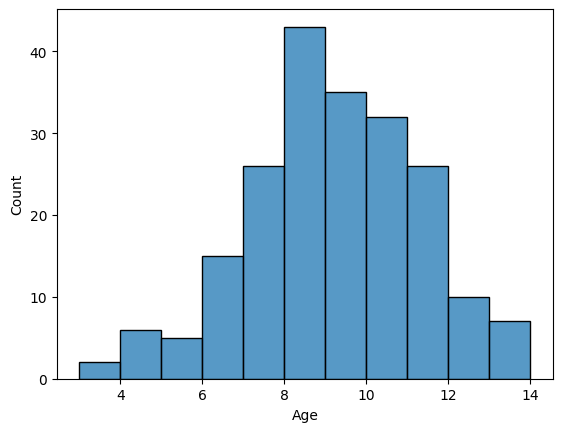

In [ ]:
# Convert 'Age' into ordered-categorical data (categorize in  5 years)  (ex. 15~19 -> "0"/ 20~24 -> "1")
# same cut-off value with PRO-ACT Preprocessing
age_min = 15   #15 is the min of PRO-ACT age value

def cat_age(age, age_min):
  return (age - age_min) // 5

demographics['Age'] = demographics.apply(lambda x: cat_age(x['Age'], age_min), axis = 1)
sns.histplot(demographics['Age'])

In [ ]:
# Female = 0, Male = 1
demographics = demographics.replace({'Gender':{"F":0, "M":1}})
demographics

,SubjectID,Gender,Age
0,1587,1,9
1,1557,0,10
2,1600,0,11
3,1584,0,10
4,1491,1,8
...,...,...,...
202,1030,1,7
203,1117,1,7
204,1231,1,8
205,1345,0,9


In [ ]:
len(demographics['SubjectID'].unique().tolist())

207

# ALSFRS-R

In [ ]:
frs['Q5 without gastrostomy'] = np.where(frs['gastrostomy'] == False, frs['Q5'], np.nan)
frs['Q5 with gastrostomy'] = np.where(frs['gastrostomy'] == True, frs['Q5'], np.nan)

frs = frs[['Study_ID', 'Date_visit', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5','Q5 without gastrostomy', 'Q5 with gastrostomy',
       'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'gastrostomy', 'ALSFRS_Total']]

In [ ]:
#Change column name and drop unnecessary columns
frs = frs.drop(columns=['gastrostomy'])
frs.columns = ['Study_ID', 'Date_visit', 'Q1_Speech', 'Q2_Salivation', 'Q3_Swallowing', 'Q4_Handwriting', 'Q5_Cutting','Q5a_Cutting_without_Gastrostomy', 'Q5b_Cutting_with_Gastrostomy',
       'Q6_Dressing_and_Hygiene', 'Q7_Turning_in_Bed', 'Q8_Walking', 'Q9_Climbing_Stairs', 'R1_Dyspnea', 'R2_Orthopnea', 'R3_Respiratory_Insufficiency','ALSFRS_R_Total']

In [ ]:
# Define function returning df with calculated feature delta for time-resolved feautures
def cal_feature_delta(df, date_enroll):
  df1 = pd.merge(df, date_enroll)
  df1['feature_delta'] = (pd.to_datetime(df1['Date_visit'])- pd.to_datetime(df1['Date_enrollment'])) / np.timedelta64(1,'D') * 12/365
  df1 = df1.sort_values(by=['SubjectID', 'feature_delta'], axis=0).reset_index().drop(columns='index')
  df1.drop(columns = ['Date_visit','Date_enrollment'], inplace = True)
  return df1

In [ ]:
frs.rename(columns = {'Study_ID':'SubjectID'},inplace=True)

date_enroll = dx[['Study_ID', 'Date_enrollment']]
date_enroll.columns=['SubjectID', 'Date_enrollment']
alsfrs_R_raw = cal_feature_delta(frs, date_enroll)


alsfrs_R_raw = alsfrs_R_raw[['SubjectID','feature_delta', 'Q1_Speech', 'Q2_Salivation', 'Q3_Swallowing', 'Q4_Handwriting', 'Q5_Cutting',
       'Q5a_Cutting_without_Gastrostomy', 'Q5b_Cutting_with_Gastrostomy',
       'Q6_Dressing_and_Hygiene', 'Q7_Turning_in_Bed', 'Q8_Walking',
       'Q9_Climbing_Stairs', 'R1_Dyspnea', 'R2_Orthopnea',
       'R3_Respiratory_Insufficiency', 'ALSFRS_R_Total' ]]
alsfrs_R_raw

,SubjectID,feature_delta,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5_Cutting,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,Q9_Climbing_Stairs,R1_Dyspnea,R2_Orthopnea,R3_Respiratory_Insufficiency,ALSFRS_R_Total
0,1003,0.000000,4,4,4,3,1,1.0,NaN,1,1,2,0,4,4,4,32
1,1003,3.912329,4,4,4,1,2,2.0,NaN,1,1,1,0,4,4,4,30
2,1003,10.356164,4,4,4,0,1,1.0,NaN,0,0,1,0,4,4,4,26
3,1003,13.117808,4,4,4,0,0,0.0,NaN,0,0,1,0,4,4,4,25
4,1003,16.339726,4,4,4,0,0,0.0,NaN,0,0,0,0,4,4,4,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1400,11872,0.000000,4,4,4,4,4,4.0,NaN,4,4,2,2,4,4,4,44
1401,11872,4.109589,4,4,4,4,3,3.0,NaN,3,3,2,1,4,4,4,40
1402,11872,5.950685,4,4,4,4,3,3.0,NaN,3,3,1,0,4,4,4,38
1403,11872,10.323288,4,4,4,3,2,2.0,NaN,3,2,1,0,4,4,4,35


In [ ]:
# Define function calculating mean
def cal_mean(df):
  df_mean = df.groupby('SubjectID').agg('mean')
  df_mean.reset_index(inplace=True) # reset 'SubjectiD' as column

  mean_df = pd.DataFrame(df_mean['SubjectID'])
  feature_list = list(df.drop(columns = ['SubjectID', 'feature_delta']).columns)

  for feature in feature_list:
    mean_df['mean_'+feature] = df_mean[feature]

  return mean_df

In [ ]:
# Define function calculating slope (Linear regression)
from sklearn.linear_model import LinearRegression
def cal_slope_LR(df):
    df_first_last = df.groupby('SubjectID').agg(['first', 'last'])
    df_first_last.reset_index(inplace=True) # reset 'SubjectiD' as column
    df_first_last['interval'] = df_first_last[('feature_delta','last')] - df_first_last[('feature_delta','first')]
    df_first_last = df_first_last[df_first_last['interval']>=1.5] # exclude data that is observed in little interval
    df =  df.query("SubjectID == {0}".format(df_first_last['SubjectID'].unique().tolist()))

    features = list(df.drop(columns = ['SubjectID', 'feature_delta']).columns)
    result = pd.DataFrame(columns=["SubjectID"] + [f"slope_{feature}" for feature in features])
    for subject_id, subject_data in df.groupby("SubjectID"):
        slopes = []
        for feature in features:
            X = subject_data[["feature_delta"]].values
            y = subject_data[feature].values
            model = LinearRegression()
            model.fit(X, y)
            slope = model.coef_[0]
            slopes.append(slope)
        result = result.append(pd.DataFrame([[subject_id] + slopes], columns=result.columns))

    return result

In [ ]:
# Define function calculating for time-resolved features
def cal_time_resolved(df):
  # Filter first 3 month data
  df_3mo = df.query('(feature_delta <= 3.0) and (feature_delta >= 0)')

  # Calculate mean
  mean_df = cal_mean(df_3mo)

  # Calculate slope
  slope_df = cal_slope_LR(df_3mo)

  # Merge mean & slope data (outer join)
  df_summary =  mean_df.merge(slope_df, on = 'SubjectID', how='outer')

  return df_summary

In [ ]:
alsfrs_R_cleaned = alsfrs_R_raw.copy()

In [ ]:
alsfrs_R_cleaned = alsfrs_R_cleaned.drop(columns=['Q5a_Cutting_without_Gastrostomy', 'Q5b_Cutting_with_Gastrostomy'])

In [ ]:
# Add alsfrs-3dimension scores
alsfrs_R_cleaned['bulbar'] = alsfrs_R_cleaned['Q1_Speech']+alsfrs_R_cleaned['Q3_Swallowing']
alsfrs_R_cleaned['motor'] = alsfrs_R_cleaned['Q4_Handwriting']+alsfrs_R_cleaned['Q5_Cutting']+alsfrs_R_cleaned['Q6_Dressing_and_Hygiene']+alsfrs_R_cleaned['Q7_Turning_in_Bed']+alsfrs_R_cleaned['Q8_Walking']+alsfrs_R_cleaned['Q9_Climbing_Stairs']
alsfrs_R_cleaned['respiratory_R'] = alsfrs_R_cleaned['R1_Dyspnea']+alsfrs_R_cleaned['R2_Orthopnea']+alsfrs_R_cleaned['R3_Respiratory_Insufficiency']

In [ ]:
# Calculate
alsfrs_R_cleaned_3mo = alsfrs_R_cleaned.query('feature_delta <= 3.0')
alsfrs_R_cleaned_3mo = alsfrs_R_cleaned_3mo.astype('float')
alsfrs_R_summary = cal_time_resolved(alsfrs_R_cleaned_3mo)

In [ ]:
len(alsfrs_R_summary['SubjectID'].unique().tolist())

207

# Target variable

In [ ]:
Filtered_3_ALSFRS_Q3 = alsfrs_R_raw[['SubjectID', 'feature_delta', 'Q3_Swallowing']]

In [ ]:
# Find the first time of [ALSFRS_Q3 <= 1.0]
Target_event = Filtered_3_ALSFRS_Q3[Filtered_3_ALSFRS_Q3['Q3_Swallowing']<=1].groupby('SubjectID').agg(['first']).reset_index()
Target_event.head()

,SubjectID,feature_delta,Q3_Swallowing
,,first,first
0,1005,29.457534,1
1,1027,6.378082,1
2,1030,24.394521,1
3,1046,24.591781,1
4,1054,11.572603,1


In [ ]:
# Coding [ALSFRS-Q3<=1] event as '1'
Target_event_1 = Target_event[[('SubjectID',''), ('feature_delta', 'first')]]
Target_event_1.columns = ['SubjectID', 'time_LOA']

Target_event_1_subject_list = list(Target_event['SubjectID'])

Target_event_1['status_LOA'] = 1
print("There are",len(Target_event_1['SubjectID'].unique()), "subjects whose loss of autonomy = 1")

# Otherwise '0'
Target_event_0 = Filtered_3_ALSFRS_Q3[~Filtered_3_ALSFRS_Q3['SubjectID'].isin(Target_event_1_subject_list)]
Target_event_0 = Target_event_0.groupby('SubjectID').agg(['last']).reset_index().drop(columns=('Q3_Swallowing', 'last'))
Target_event_0.columns = ['SubjectID', 'time_LOA']
Target_event_0['status_LOA'] = 0
print("There are",len(Target_event_0['SubjectID'].unique()), "subjects whose loss of autonomy = 0")

 # There are 41 subjects whose Event = 1
 # There are 166 subjects whose Event = 0

There are 41 subjects whose loss of autonomy = 1
There are 166 subjects whose loss of autonomy = 0


In [ ]:
ALFRS_Q3_coded = pd.concat([Target_event_1, Target_event_0]).sort_values(by='SubjectID', axis=0)
ALFRS_Q3_coded = ALFRS_Q3_coded.reset_index()
ALFRS_Q3_coded.drop(columns='index', inplace=True)

Target_Data = ALFRS_Q3_coded.copy()
Target_Data_subject_list = list(Target_Data['SubjectID'])
Target_Data #207 data

,SubjectID,time_LOA,status_LOA
0,1003,30.641096,0
1,1005,29.457534,1
2,1010,3.912329,0
3,1017,4.635616,0
4,1019,42.476712,0
...,...,...,...
202,1901,4.668493,0
203,1915,4.109589,0
204,1921,3.057534,0
205,11871,12.361644,0


In [ ]:
print(len(Target_Data.query('time_LOA <= 3.0')['SubjectID'].tolist()), 'patients has time_LOA 3 month or less')

0 patients has time_LOA 3 month or less


In [ ]:
Target_Data_snuh = Target_Data.query('time_LOA > 3.0')

# minus 3months for target data value
Target_Data_snuh['time_LOA'] = Target_Data_snuh['time_LOA'] -3.0

Target_Data_snuh

,SubjectID,time_LOA,status_LOA
0,1003,27.641096,0
1,1005,26.457534,1
2,1010,0.912329,0
3,1017,1.635616,0
4,1019,39.476712,0
...,...,...,...
202,1901,1.668493,0
203,1915,1.109589,0
204,1921,0.057534,0
205,11871,9.361644,0


In [ ]:
len(Target_Data_snuh['SubjectID'].unique().tolist())

207

In [ ]:
# Note that 'time_LOA' is month scaled

#  FVC

In [ ]:
FVC

,Study_ID,Date,feature_delta,FVC
0,1005,2017-05-15,0.0,77
1,1039,2017-05-22,0.0,90
2,1459,2019-11-05,0.0,92
3,1513,2020-02-18,0.0,69
4,11871,2017-12-27,0.0,96
...,...,...,...,...
332,1521,2020-03-03,31.3,92
333,1353,2022-03-07,35.2,51
334,1021,2020-07-27,39.0,52
335,1069,2020-12-14,42.1,52


In [ ]:
fvc = FVC[['Study_ID','Date', 'FVC']].query("Study_ID == {0}".format(Target_Data_snuh['SubjectID'].unique().tolist()))
fvc.columns = ['Study_ID', 'Date_visit', 'FVC']

In [ ]:
fvc.rename(columns = {'Study_ID':'SubjectID', 'FVC':'fvc'},inplace=True)
FVC = cal_feature_delta(fvc, date_enroll)

In [ ]:
fvc_summary = cal_time_resolved(FVC)
fvc_summary

<ipython-input-50-0a87a0cfe8c4>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.DataFrame([[subject_id] + slopes], columns=result.columns))
<ipython-input-50-0a87a0cfe8c4>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.DataFrame([[subject_id] + slopes], columns=result.columns))
<ipython-input-50-0a87a0cfe8c4>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.DataFrame([[subject_id] + slopes], columns=result.columns))
<ipython-input-50-0a87a0cfe8c4>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.DataFrame([[subject_id] + slopes

,SubjectID,mean_fvc,slope_fvc
0,1003,91.0,NaN
1,1005,77.0,NaN
2,1017,46.5,-1.357118
3,1019,77.0,NaN
4,1020,75.0,NaN
...,...,...,...
113,1636,121.0,NaN
114,1650,79.0,NaN
115,1722,89.0,NaN
116,11871,96.0,NaN


# Weight

In [ ]:
wt = WT[['Study_ID', 'Date', 'Wt']].query("Study_ID == {0}".format(Target_Data_snuh['SubjectID'].unique().tolist()))
wt

,Study_ID,Date,Wt
0,11872,2017-12-12,85.0
1,1800,2021-11-22,56.0
2,1794,2021-11-08,59.0
3,1793,2021-11-08,73.0
4,1749,2021-08-23,72.0
...,...,...,...
1175,1222,2022-11-21,60.0
1176,1311,2023-08-28,66.0
1177,1060,2022-03-07,NaN
1178,1060,2022-06-27,54.0


In [ ]:
# 91 values are missing, so drop them
wt.isnull().sum()

Study_ID     0
Date         0
Wt          91
dtype: int64

In [ ]:
wt = wt.dropna()

In [ ]:
wt.rename(columns = {'Study_ID':'SubjectID', 'Date':'Date_visit', 'Wt':'weight'},inplace=True)

<ipython-input-71-a19cb0900de5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wt.rename(columns = {'Study_ID':'SubjectID', 'Date':'Date_visit', 'Wt':'weight'},inplace=True)


In [ ]:
weight = cal_feature_delta(wt, date_enroll)
weight_summary = cal_time_resolved(weight)

<ipython-input-50-0a87a0cfe8c4>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.DataFrame([[subject_id] + slopes], columns=result.columns))
<ipython-input-50-0a87a0cfe8c4>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.DataFrame([[subject_id] + slopes], columns=result.columns))
<ipython-input-50-0a87a0cfe8c4>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.DataFrame([[subject_id] + slopes], columns=result.columns))
<ipython-input-50-0a87a0cfe8c4>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.DataFrame([[subject_id] + slopes

In [ ]:
weight_summary

,SubjectID,mean_weight,slope_weight
0,1003,62.0,NaN
1,1005,69.0,NaN
2,1010,71.0,NaN
3,1017,51.5,-1.382576
4,1019,56.0,0.000000
...,...,...,...
182,1812,54.0,NaN
183,1882,58.5,NaN
184,1889,63.0,NaN
185,1921,68.6,NaN


In [ ]:
len(weight_summary['SubjectID'].unique().tolist())

187

# Creatinine

In [ ]:
cr = CR.query("Study_ID == {0}".format(Target_Data_snuh['SubjectID'].unique().tolist())) #include only ALS patients
cr.rename(columns = {'Study_ID':'SubjectID', 'Date':'Date_visit', 'Cr':'creatinine'},inplace=True)
cr = cr.drop(columns=['feature_delta'])
cr

,SubjectID,Date_visit,creatinine
0,11871,2017-12-26,0.88
1,1557,2020-01-30,0.68
2,1537,2020-05-18,0.67
3,1521,2017-07-24,0.69
4,1513,2020-02-18,0.94
...,...,...,...
527,1005,2020-02-10,0.44
528,1063,2020-07-31,0.41
529,1019,2020-06-14,0.27
530,1021,2020-06-24,0.36


In [ ]:
#adjust the measure unit (from mg/dL to micromol/L)
cr[['creatinine']] = cr[['creatinine']].apply(pd.to_numeric)
cr['creatinine_mmol_per_liter'] = cr['creatinine']*88.4
cr = cr[['SubjectID', 'Date_visit', 'creatinine_mmol_per_liter']]
cr.columns = ['SubjectID', 'Date_visit', 'creatinine']
cr.sort_values('Date_visit')

,SubjectID,Date_visit,creatinine
36,1021,2017-05-01,47.736
48,1021,2017-05-04,45.968
47,1031,2017-05-22,60.112
73,1030,2017-06-06,67.184
18,1063,2017-06-12,54.808
...,...,...,...
286,1587,2021-07-26,58.344
421,1530,2021-07-27,53.040
480,1401,2021-07-29,38.896
424,1530,2021-07-29,52.156


In [ ]:
creatinine = cal_feature_delta(cr, date_enroll)
creatinine = creatinine.astype('float')
creatinine_summary = cal_time_resolved(creatinine)
creatinine_summary.columns=['SubjectID', 'mean_creatinine', 'slope_creatinine']

<ipython-input-50-0a87a0cfe8c4>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.DataFrame([[subject_id] + slopes], columns=result.columns))
<ipython-input-50-0a87a0cfe8c4>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.DataFrame([[subject_id] + slopes], columns=result.columns))
<ipython-input-50-0a87a0cfe8c4>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.DataFrame([[subject_id] + slopes], columns=result.columns))
<ipython-input-50-0a87a0cfe8c4>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.DataFrame([[subject_id] + slopes

In [ ]:
creatinine_summary

,SubjectID,mean_creatinine,slope_creatinine
0,1005.0,71.309333,NaN
1,1017.0,54.808000,NaN
2,1021.0,45.968000,-1.321649
3,1030.0,67.184000,NaN
4,1031.0,67.714400,4.638532
...,...,...,...
81,1615.0,75.140000,NaN
82,1620.0,59.228000,NaN
83,1642.0,72.488000,NaN
84,11871.0,79.118000,NaN


# Merge all

In [ ]:
ALS_hx_v2 = ALS_hx2.rename(columns = {'Study_ID':'SubjectID'})

In [ ]:
ALS_hx2

,Study_ID,onset_site,onset_delta,diag_delta,diag_minus_onset
0,1587,0,5.0,1.0,-4.0
1,1557,1,21.0,9.0,-12.0
2,1600,0,30.0,10.0,-20.0
3,1584,1,11.0,7.0,-4.0
4,1491,0,13.0,1.0,-12.0
...,...,...,...,...,...
202,1030,0,13.0,0.0,-13.0
203,1117,0,19.0,6.0,-13.0
204,1231,1,10.0,9.0,-1.0
205,1345,0,12.0,2.0,-10.0


In [ ]:
# Outer join all features to allow missing data
features_df = pd.DataFrame(columns=['SubjectID'])
feature_list = [demographics, ALS_hx_v2, alsfrs_R_summary, fvc_summary, creatinine_summary, weight_summary]
for i in feature_list :
    df = i
    features_df = features_df.merge(df, on='SubjectID', how='outer')
features_snuh = features_df.query("SubjectID == {0}".format(Target_Data_snuh['SubjectID'].unique().tolist()))
features_snuh

,SubjectID,Gender,Age,onset_site,onset_delta,diag_delta,diag_minus_onset,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,...,slope_ALSFRS_R_Total,slope_bulbar,slope_motor,slope_respiratory_R,mean_fvc,slope_fvc,mean_creatinine,slope_creatinine,mean_weight,slope_weight
0,1587,1,9,0,5.0,1.0,-4.0,4.0,4.0,4.000000,...,NaN,NaN,NaN,NaN,77.0,NaN,64.532000,NaN,58.0,NaN
1,1557,0,10,1,21.0,9.0,-12.0,3.0,4.0,3.000000,...,NaN,NaN,NaN,NaN,78.0,NaN,54.513333,1.339477,NaN,NaN
2,1600,0,11,0,30.0,10.0,-20.0,3.0,4.0,4.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,60.996000,NaN,57.0,NaN
3,1584,0,10,1,11.0,7.0,-4.0,4.0,4.0,3.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,NaN
4,1491,1,8,0,13.0,1.0,-12.0,3.0,4.0,4.000000,...,NaN,NaN,NaN,NaN,76.0,NaN,NaN,NaN,62.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,1030,1,7,0,13.0,0.0,-13.0,4.0,4.0,4.000000,...,NaN,NaN,NaN,NaN,76.0,NaN,67.184000,NaN,64.0,NaN
203,1117,1,7,0,19.0,6.0,-13.0,3.0,4.0,3.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,65.416000,NaN,71.0,NaN
204,1231,1,8,1,10.0,9.0,-1.0,1.0,2.0,2.500000,...,-1.303571,0.434524,-1.738095,0.000000,75.0,NaN,NaN,NaN,65.0,-1.738095
205,1345,0,9,0,12.0,2.0,-10.0,4.0,4.0,3.666667,...,-3.145186,0.393148,-1.982712,-1.555623,NaN,NaN,82.801333,NaN,57.5,0.366466


In [ ]:
Features_and_Target_final_snuh = features_snuh.merge(Target_Data_snuh, on='SubjectID', how='outer')
Features_and_Target_final_snuh.sort_values(by='SubjectID', ascending=True, inplace=True)
Features_and_Target_final_snuh = Features_and_Target_final_snuh.query("SubjectID == {0}".format(Target_Data_snuh['SubjectID'].unique().tolist()))
Features_and_Target_final_snuh

,SubjectID,Gender,Age,onset_site,onset_delta,diag_delta,diag_minus_onset,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,...,slope_motor,slope_respiratory_R,mean_fvc,slope_fvc,mean_creatinine,slope_creatinine,mean_weight,slope_weight,time_LOA,status_LOA
32,1003,0,10,0,18.0,4.0,-14.0,4.0,4.0,4.000000,...,NaN,NaN,91.0,NaN,NaN,NaN,62.0,NaN,27.641096,0
167,1005,1,3,0,5.0,2.0,-3.0,4.0,4.0,4.000000,...,-2.414021,0.000000,77.0,NaN,71.309333,NaN,69.0,NaN,26.457534,1
51,1010,0,10,0,23.0,8.0,-15.0,4.0,4.0,3.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,71.0,NaN,0.912329,0
201,1017,0,11,1,7.0,1.0,-6.0,2.5,3.0,3.000000,...,1.843434,-1.843434,46.5,-1.357118,54.808000,NaN,51.5,-1.382576,1.635616,0
165,1019,0,9,0,17.0,5.0,-12.0,4.0,4.0,3.500000,...,-0.668498,0.000000,77.0,NaN,NaN,NaN,56.0,0.000000,39.476712,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,1901,0,11,1,13.0,7.0,-6.0,1.5,2.5,2.500000,...,1.448413,0.362103,NaN,NaN,NaN,NaN,NaN,NaN,1.668493,0
154,1915,1,10,0,42.0,1.0,-41.0,3.0,2.0,3.000000,...,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.109589,0
155,1921,1,7,1,9.0,1.0,-8.0,3.0,4.0,3.333333,...,-1.596675,-0.399169,NaN,NaN,NaN,NaN,68.6,NaN,0.057534,0
74,11871,1,9,1,12.0,2.0,-10.0,3.0,3.0,3.000000,...,NaN,NaN,96.0,NaN,79.118000,NaN,NaN,NaN,9.361644,0


### Check missing data proportion

The column slope_Q1_Speech has 105 null values. It is 50.72% of total rows.
The column slope_Q1_Speech is of type float64.

The column slope_Q2_Salivation has 105 null values. It is 50.72% of total rows.
The column slope_Q2_Salivation is of type float64.

The column slope_Q3_Swallowing has 105 null values. It is 50.72% of total rows.
The column slope_Q3_Swallowing is of type float64.

The column slope_Q4_Handwriting has 105 null values. It is 50.72% of total rows.
The column slope_Q4_Handwriting is of type float64.

The column slope_Q5_Cutting has 105 null values. It is 50.72% of total rows.
The column slope_Q5_Cutting is of type float64.

The column slope_Q6_Dressing_and_Hygiene has 105 null values. It is 50.72% of total rows.
The column slope_Q6_Dressing_and_Hygiene is of type float64.

The column slope_Q7_Turning_in_Bed has 105 null values. It is 50.72% of total rows.
The column slope_Q7_Turning_in_Bed is of type float64.

The column slope_Q8_Walking has 105 null values. It is 50.72

['slope_Q1_Speech',
 'slope_Q2_Salivation',
 'slope_Q3_Swallowing',
 'slope_Q4_Handwriting',
 'slope_Q5_Cutting',
 'slope_Q6_Dressing_and_Hygiene',
 'slope_Q7_Turning_in_Bed',
 'slope_Q8_Walking',
 'slope_Q9_Climbing_Stairs',
 'slope_R1_Dyspnea',
 'slope_R2_Orthopnea',
 'slope_R3_Respiratory_Insufficiency',
 'slope_ALSFRS_R_Total',
 'slope_bulbar',
 'slope_motor',
 'slope_respiratory_R',
 'mean_fvc',
 'slope_fvc',
 'mean_creatinine',
 'slope_creatinine',
 'slope_weight']

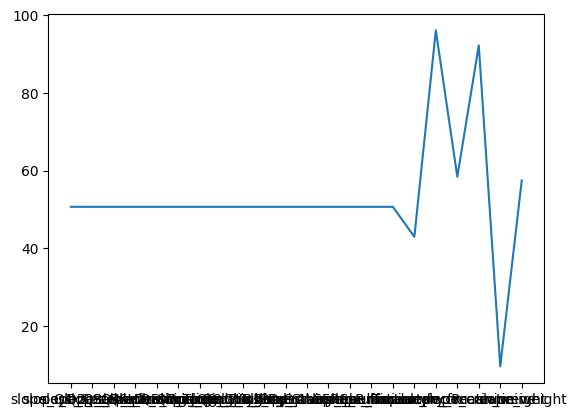

In [ ]:
def report_nulls(df):
    '''
    Show a fast report of the DF.
    '''
    rows = df.shape[0]
    columns = df.shape[1]
    null_cols = 0
    list_of_nulls_cols = []
    list_of_nulls_cols_pcn = []
    list_of_nulls_cols_over40 = []
    for col in list(df.columns):
        null_values_rows = df[col].isnull().sum()
        null_rows_pcn = round(((null_values_rows)/rows)*100, 2)
        col_type = df[col].dtype
        if null_values_rows > 0:
            print("The column {} has {} null values. It is {}% of total rows.".format(col, null_values_rows, null_rows_pcn))
            print("The column {} is of type {}.\n".format(col, col_type))
            null_cols += 1
            list_of_nulls_cols.append(col)
            list_of_nulls_cols_pcn.append(null_rows_pcn)
            if null_rows_pcn > 40:
                list_of_nulls_cols_over40.append(col)
    null_cols_pcn = round((null_cols/columns)*100, 2)
    print("The DataFrame has {} columns with null values. It is {}% of total columns.".format(null_cols, null_cols_pcn))
    plt.plot(list_of_nulls_cols, list_of_nulls_cols_pcn)
    return list_of_nulls_cols_over40

report_nulls(Features_and_Target_final_snuh)

## Save to preprocessed_csv files

In [ ]:
Features_and_Target_final_snuh.to_csv('/content/drive/MyDrive/Predicting Loss of Autonomy/1. Swallowing/Jul 2022 PRO-ACT data (latest update)/Files/X_and_Y_SNUH_with_NaNs.csv')